In [2]:
!pip install pygrok

  Preparing metadata (setup.py) ... done
  Created wheel for pygrok: filename=pygrok-1.0.0-py3-none-any.whl size=21725 sha256=1719600a26d12f3a91acac582c97bd84c0bfa598ff6459790a42ca5ba698cbdf
  Stored in directory: /root/.cache/pip/wheels/61/36/5d/7cbf2201c0bcddcb3b5eb5bc24324d1e938c360aaf3ffb5762
Successfully built pygrok


In [3]:
# ===========================================================================================
# CELL 1: IMPORTS & CONFIGURATION
# ===========================================================================================
"""
Mathematical Libraries:
- statsmodels: Time series analysis (ARIMA, decomposition, tests)
- scipy: Statistical functions (Box-Cox, distributions)
- sklearn: Preprocessing (scaling, outlier detection)
"""

# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import gc
warnings.filterwarnings('ignore')

# Data parsing
from pygrok import Grok
from tqdm.auto import tqdm

# Statistical analysis
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from scipy.optimize import minimize_scalar

# Time series specific
from statsmodels.tsa.stattools import (
    adfuller,           # Augmented Dickey-Fuller test (stationarity)
    kpss,               # Kwiatkowski-Phillips-Schmidt-Shin test
    acf, pacf,          # Autocorrelation functions
    ccf                 # Cross-correlation function
)
from statsmodels.tsa.seasonal import (
    STL,                # Seasonal-Trend decomposition using LOESS
    seasonal_decompose  # Classical decomposition
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine learning
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler
)
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.family'] = 'sans-serif'

# Random seed for reproducibility
np.random.seed(42)

print("✓ Libraries loaded successfully")
print(f"  NumPy version: {np.__version__}")
print(f"  Pandas version: {pd.__version__}")

# ===========================================================================================
# GLOBAL CONSTANTS
# ===========================================================================================

# NASA Dataset specifics
STORM_START = pd.Timestamp('1995-08-01 14:52:01')
STORM_END = pd.Timestamp('1995-08-03 04:36:13')

# Grok pattern for Apache Combined Log Format
GROK_PATTERN = r'%{IPORHOST:host} - - \[%{HTTPDATE:timestamp}\] "%{WORD:method} %{DATA:url} HTTP/%{NUMBER:http_version}" %{NUMBER:status} (?:%{NUMBER:bytes}|-)'
grok = Grok(GROK_PATTERN)

# Processing parameters
CHUNK_SIZE = 100000  # For memory-efficient parsing

# Statistical significance levels
ALPHA = 0.05  # 95% confidence

print("\n✓ Configuration complete")
print(f"  Storm period: {STORM_START} to {STORM_END}")
print(f"  Significance level: α = {ALPHA}")

✓ Libraries loaded successfully
  NumPy version: 2.0.2
  Pandas version: 2.2.2

✓ Configuration complete
  Storm period: 1995-08-01 14:52:01 to 1995-08-03 04:36:13
  Significance level: α = 0.05


In [4]:
# ===========================================================================================
# CELL 2: MEMORY-EFFICIENT LOG PARSING
# ===========================================================================================
"""
Objective: Parse raw Apache logs into structured DataFrame

Mathematical Considerations:
- Chunked processing to avoid O(n) memory complexity
- Streaming algorithm: Process in O(1) space per chunk

Performance:
- Time complexity: O(n) where n = number of log lines
- Space complexity: O(chunk_size) instead of O(n)
"""

def count_lines(filepath):
    """Count total lines for progress bar (1-pass scan)."""
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)


def parse_log_file(filepath, chunk_size=CHUNK_SIZE, verbose=True):
    """
    Parse log file in chunks with progress tracking.

    Args:
        filepath: Path to log file
        chunk_size: Number of lines per chunk (memory optimization)
        verbose: Print progress information

    Returns:
        pd.DataFrame: Parsed log data

    Algorithm:
        1. Stream file line-by-line
        2. Apply Grok pattern matching (regex)
        3. Accumulate into chunk_records
        4. When chunk full → convert to DataFrame → append to chunks list
        5. Force garbage collection to free memory
        6. Concatenate all chunks at the end
    """
    if verbose:
        print(f"\n[PARSING] {filepath}")
        total_lines = count_lines(filepath)
        print(f"  Total lines: {total_lines:,}")
        pbar = tqdm(total=total_lines, desc="  Parsing", unit=" lines")

    chunks = []
    chunk_records = []
    parsed_count = 0
    error_count = 0

    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            match = grok.match(line.strip())

            if match:
                chunk_records.append(match)
                parsed_count += 1
            else:
                error_count += 1

            # Chunk is full → convert to DataFrame
            if len(chunk_records) >= chunk_size:
                chunks.append(pd.DataFrame(chunk_records))
                chunk_records = []
                gc.collect()  # Force garbage collection

            if verbose:
                pbar.update(1)

        # Process remaining records
        if chunk_records:
            chunks.append(pd.DataFrame(chunk_records))

    if verbose:
        pbar.close()
        print(f"  ✓ Parsed: {parsed_count:,} valid, {error_count:,} errors")
        print(f"    Success rate: {100*parsed_count/(parsed_count+error_count):.2f}%")

    # Concatenate all chunks
    df = pd.concat(chunks, ignore_index=True)
    del chunks
    gc.collect()

    return df


def normalize_dtypes(df, verbose=True):
    """
    Type conversion and timezone handling.

    Mathematical Notes:
    - Timestamps: Convert to datetime64[ns] for uniform time representation
    - Timezone: Remove tz info while preserving local time (avoid 4-hour offset issues)
    - Numeric types: Use appropriate precision (int32 for status, float64 for bytes)
    """
    df = df.copy()

    if verbose:
        print("\n[TYPE NORMALIZATION]")

    # Parse timestamp with timezone
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')

    if verbose and df['timestamp'].dt.tz is not None:
        sample_tz = df['timestamp'].iloc[0].tz
        print(f"  Original timezone: {sample_tz}")
        print(f"  Sample: {df['timestamp'].iloc[0]}")

    # Remove timezone (keep local time)
    df['timestamp'] = df['timestamp'].dt.tz_localize(None)

    # Numeric conversions
    df['status'] = pd.to_numeric(df['status'], errors='coerce').fillna(0).astype(np.int32)
    df['bytes'] = pd.to_numeric(df['bytes'], errors='coerce').fillna(0).astype(np.float64)

    # Sort by timestamp (required for time series)
    df = df.sort_values('timestamp').reset_index(drop=True)

    # Remove invalid timestamps
    df = df.dropna(subset=['timestamp'])

    if verbose:
        print(f"  ✓ Records after cleaning: {len(df):,}")
        print(f"  ✓ Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        print(f"  ✓ Duration: {df['timestamp'].max() - df['timestamp'].min()}")

    return df


print("✓ Parsing functions defined")
print("\nReady to parse log files.")

✓ Parsing functions defined

Ready to parse log files.


In [5]:
# ===========================================================================================
# CELL 3: FEATURE ENGINEERING WITH MATHEMATICAL RIGOR
# ===========================================================================================
"""
Objective: Create statistically meaningful features

Features:
1. weighted_load: SLA-aware metric
   - Based on HTTP status code severity
   - 5xx errors → high impact (weight=5)
   - 4xx errors → medium impact (weight=1.5)
   - 2xx success → normal (weight=1)

2. bytes_cleaned: Robust outlier handling
   - P99 quantile capping (prevents extreme values)
   - Preserves distribution shape for percentiles < 99

3. is_static: Binary feature
   - Static content (images, CSS, JS) vs dynamic (APIs, HTML)
   - Important for workload characterization

Mathematical Justification:
- weighted_load: E[Load] with importance weighting
- P99 capping: Robust to heavy-tailed distributions
"""

def engineer_features(df, p99_threshold=None, verbose=True):
    """
    Create features for autoscaling prediction.

    Args:
        df: Raw parsed DataFrame
        p99_threshold: Pre-computed P99 threshold (for train/test consistency)
        verbose: Print statistics

    Returns:
        df: DataFrame with new features
        p99_threshold: Computed P99 value (for reuse on test set)
    """
    df = df.copy()

    if verbose:
        print("\n[FEATURE ENGINEERING]")

    # ───────────────────────────────────────────────────────────────────────────────────────
    # 1. WEIGHTED LOAD (SLA Impact Metric)
    # ───────────────────────────────────────────────────────────────────────────────────────
    """
    Rationale: Not all requests have equal impact on system health.
    - 5xx errors indicate server failure → immediate attention needed
    - 4xx errors indicate client issues → moderate concern
    - 2xx success → normal operation

    Mathematical formulation:
    weighted_load_i = w(status_i) where
    w(s) = {5.0 if s≥500, 1.5 if 400≤s<500, 1.0 if 200≤s<400, 1.0 otherwise}
    """
    conditions = [
    (df['status'] >= 500),                         # 5xx: server error
    (df['status'] >= 400) & (df['status'] < 500),  # 4xx: client error
    (df['status'] >= 300) & (df['status'] < 400),  # 3xx: redirect
    (df['status'] >= 200) & (df['status'] < 300)   # 2xx: success
    ]

    weights = [
        1.5,  # 5xx: stress cao nhưng tránh quá nhạy
        0.5,  # 4xx: fail sớm, rẻ hơn 200
        0.2,  # 3xx: KHÔNG free
        1.0   # 2xx: baseline
    ]

    df['weighted_load'] = np.select(conditions, weights, default=1.0)

    if verbose:
        status_dist = pd.cut(df['status'], bins=[0, 199, 299, 399, 499, 600],
                            labels=['1xx', '2xx', '3xx', '4xx', '5xx']).value_counts()
        print(f"  Status distribution:")
        for status, count in status_dist.items():
            pct = 100 * count / len(df)
            print(f"    {status}: {count:,} ({pct:.2f}%)")
        print(f"  weighted_load: μ={df['weighted_load'].mean():.3f}, σ={df['weighted_load'].std():.3f}")

    # ───────────────────────────────────────────────────────────────────────────────────────
    # 2. STATIC CONTENT CLASSIFICATION
    # ───────────────────────────────────────────────────────────────────────────────────────
    """
    Rationale: Static content (images, CSS) has different resource profile than dynamic.
    - Static: High I/O, low CPU
    - Dynamic: Variable CPU, database queries
    """
    static_extensions = (
        '.gif', '.jpg', '.jpeg', '.png', '.svg', '.webp',  # Images
        '.css', '.js',                                      # Stylesheets, scripts
        '.html', '.htm', '.txt',                           # Static pages
        '.ico', '.woff', '.woff2', '.ttf', '.eot'          # Fonts, icons
    )
    df['is_static'] = df['url'].str.lower().str.endswith(static_extensions).astype(np.int8)

    if verbose:
        static_pct = df['is_static'].mean() * 100
        print(f"  Static content: {static_pct:.1f}% of requests")

    # ───────────────────────────────────────────────────────────────────────────────────────
    # 3. OUTLIER HANDLING (P99 QUANTILE CAPPING)
    # ───────────────────────────────────────────────────────────────────────────────────────
    """
    Rationale: Response sizes follow heavy-tailed distribution.
    - Majority: <500KB (HTML, images)
    - Outliers: >100MB (video, large downloads)

    Problem: Outliers inflate mean, mislead aggregations.
    Solution: P99 quantile capping (Tukey's fences variation).

    Mathematical justification:
    Let X ~ heavy-tailed distribution
    Define: X_capped = min(X, P99(X))
    Then: Var[X_capped] << Var[X], E[X_capped] more robust
    """
    if p99_threshold is None:
        p99_threshold = df['bytes'].quantile(0.99)
        if verbose:
            print(f"  \nBytes distribution (before capping):")
            print(f"    Mean: {df['bytes'].mean():,.0f} bytes")
            print(f"    Median: {df['bytes'].median():,.0f} bytes")
            print(f"    P99: {p99_threshold:,.0f} bytes")
            print(f"    Max: {df['bytes'].max():,.0f} bytes")

    df['bytes_cleaned'] = df['bytes'].clip(upper=p99_threshold)

    if verbose:
        outliers_count = (df['bytes'] > p99_threshold).sum()
        print(f"    Outliers capped: {outliers_count:,} ({100*outliers_count/len(df):.2f}%)")
        print(f"  \nBytes distribution (after capping):")
        print(f"    Mean: {df['bytes_cleaned'].mean():,.0f} bytes")
        print(f"    Median: {df['bytes_cleaned'].median():,.0f} bytes")
        print(f"    Std: {df['bytes_cleaned'].std():,.0f} bytes")

    # ───────────────────────────────────────────────────────────────────────────────────────
    # 4. TEMPORAL FEATURES (for later use in models)
    # ───────────────────────────────────────────────────────────────────────────────────────
    """
    Extract cyclical time features (hour, day_of_week) for:
    - Prophet: External regressors
    - LSTM: Additional input features
    """
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int8)

    if verbose:
        print(f"\n  ✓ Features created: weighted_load, is_static, bytes_cleaned")
        print(f"  ✓ Temporal features: hour, day_of_week, is_weekend")

    return df, p99_threshold


print("✓ Feature engineering functions defined")

✓ Feature engineering functions defined


In [ ]:
# ===========================
# CELL 4: LOAD & PROCESS DATA
# ===========================

# Paths - CẬP NHẬT ĐƯỜNG DẪN CỦA BẠN
TRAIN_PATH = 'data/raw_data/train.txt'
TEST_PATH = 'data/raw_data/test.txt'

print("="*60)
print("BƯỚC 1: PARSING RAW LOGS")
print("="*60)

# Parse
train_raw = parse_log_file(TRAIN_PATH)
test_raw = parse_log_file(TEST_PATH)

# Normalize
print("\n[NORMALIZING] Data types...")
train_df = normalize_dtypes(train_raw)
test_df = normalize_dtypes(test_raw)

print("\n" + "="*60)
print("BƯỚC 2: FEATURE ENGINEERING")
print("="*60)

# Engineer features (train first để tính P99 threshold)
train_df, p99_threshold_ = engineer_features(train_df)
test_df, _ = engineer_features(test_df, p99_threshold=p99_threshold_)

print(f"\n✓ P99 Bytes Threshold: {p99_threshold_:,.0f} bytes")
print(f"✓ Train records: {len(train_df):,}")
print(f"✓ Test records: {len(test_df):,}")

# Display sample
print("\n[SAMPLE] Processed Train Data:")
display(train_df[['timestamp', 'host', 'status', 'bytes', 'weighted_load', 'is_static']].head(10))

BƯỚC 1: PARSING RAW LOGS

[PARSING] /content/drive/MyDrive/AUTOSCALING ANALYSIS/DATA/train.txt
  Total lines: 2,934,961


  Parsing:   0%|          | 0/2934961 [00:00<?, ? lines/s]

  ✓ Parsed: 2,929,723 valid, 5,238 errors
    Success rate: 99.82%

[PARSING] /content/drive/MyDrive/AUTOSCALING ANALYSIS/DATA/test.txt
  Total lines: 526,651


  Parsing:   0%|          | 0/526651 [00:00<?, ? lines/s]

  ✓ Parsed: 525,281 valid, 1,370 errors
    Success rate: 99.74%

[NORMALIZING] Data types...

[TYPE NORMALIZATION]
  Original timezone: UTC-04:00
  Sample: 1995-07-01 00:00:01-04:00
  ✓ Records after cleaning: 2,929,723
  ✓ Date range: 1995-07-01 00:00:01 to 1995-08-22 23:59:59
  ✓ Duration: 52 days 23:59:58

[TYPE NORMALIZATION]
  Original timezone: UTC-04:00
  Sample: 1995-08-23 00:00:00-04:00
  ✓ Records after cleaning: 525,281
  ✓ Date range: 1995-08-23 00:00:00 to 1995-08-31 23:59:53
  ✓ Duration: 8 days 23:59:53

BƯỚC 2: FEATURE ENGINEERING

[FEATURE ENGINEERING]
  Status distribution:
    2xx: 2,637,404 (90.02%)
    3xx: 275,226 (9.39%)
    4xx: 16,998 (0.58%)
    5xx: 95 (0.00%)
    1xx: 0 (0.00%)
  weighted_load: μ=0.922, σ=0.236
  Static content: 83.8% of requests
  
Bytes distribution (before capping):
    Mean: 19,412 bytes
    Median: 3,626 bytes
    P99: 266,273 bytes
    Max: 6,823,936 bytes
    Outliers capped: 29,138 (0.99%)
  
Bytes distribution (after capping):
    

,timestamp,host,status,bytes,weighted_load,is_static
0,1995-07-01 00:00:01,199.72.81.55,200,6245.0,1.0,0
1,1995-07-01 00:00:06,unicomp6.unicomp.net,200,3985.0,1.0,0
2,1995-07-01 00:00:09,199.120.110.21,200,4085.0,1.0,1
3,1995-07-01 00:00:11,burger.letters.com,304,0.0,0.2,1
4,1995-07-01 00:00:11,199.120.110.21,200,4179.0,1.0,1
5,1995-07-01 00:00:12,burger.letters.com,304,0.0,0.2,1
6,1995-07-01 00:00:12,burger.letters.com,200,0.0,1.0,1
7,1995-07-01 00:00:12,205.212.115.106,200,3985.0,1.0,1
8,1995-07-01 00:00:13,129.94.144.152,200,7074.0,1.0,0
9,1995-07-01 00:00:13,d104.aa.net,200,3985.0,1.0,0


In [7]:
# ===========================================================================================
# CELL 4: TIME SERIES AGGREGATION (WATERFALL IMPUTATION & TOTAL BYTES)
# ===========================================================================================
import numpy as np
import pandas as pd

# Cấu hình vùng bão (Đảm bảo biến này đã được khai báo trước đó)
STORM_START = pd.Timestamp('1995-08-01 14:52:01')
STORM_END   = pd.Timestamp('1995-08-03 04:36:13')

def aggregate_to_timeseries(df, freq='5min', verbose=True):
    """
    Chuyển đổi Log thành Time Series với logic xử lý bão (Waterfall) và đầy đủ metrics.
    """
    df = df.copy()

    # 1. CHUẨN BỊ INDEX
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'timestamp' in df.columns:
            df = df.set_index('timestamp')
        else:
            df.index = pd.to_datetime(df.index)

    if verbose:
        print(f"\n[TIME SERIES AGGREGATION - {freq}]")
        print(f"  Input records: {len(df):,}")

    # ---------------------------------------------------------
    # STEP 1: RESAMPLING (GOM NHÓM)
    # ---------------------------------------------------------
    # Xác định cột Bytes (để tính total_bytes)
    byte_col = None
    if 'bytes_cleaned' in df.columns: byte_col = 'bytes_cleaned'
    elif 'bytes' in df.columns: byte_col = 'bytes'
    elif 'response_size' in df.columns: byte_col = 'response_size'

    # Định nghĩa rule gom nhóm
    agg_dict = {
        'weighted_load': 'sum',      # Tổng tải trọng
        'host': 'nunique',           # Đếm số lượng user (Unique IPs)
        'is_static': 'mean'          # Tỉ lệ nội dung tĩnh
    }

    # Thêm cột bytes vào rule nếu tìm thấy
    if byte_col:
        agg_dict[byte_col] = 'sum'

    # Thực hiện Resample
    # Lưu ý: Tính request_count riêng bằng .size() sẽ nhanh và chuẩn hơn
    requests = df.resample(freq).size().rename('request_count')
    features = df.resample(freq).agg(agg_dict)

    ts_df = pd.concat([requests, features], axis=1)

    # Đổi tên cột về chuẩn chung
    rename_map = {'host': 'unique_users', 'is_static': 'static_ratio'}
    if byte_col:
        rename_map[byte_col] = 'total_bytes'

    ts_df.rename(columns=rename_map, inplace=True)

    # Nếu không có total_bytes (do thiếu cột gốc), tạo cột 0
    if 'total_bytes' not in ts_df.columns:
        ts_df['total_bytes'] = 0.0

    # ---------------------------------------------------------
    # STEP 2: CONTINUOUS INDEX & OUTAGE MARKING
    # ---------------------------------------------------------
    # Tạo trục thời gian liên tục (lấp đầy các khoảng trống bằng NaN)
    full_index = pd.date_range(start=ts_df.index.min(),
                               end=ts_df.index.max(),
                               freq=freq)
    ts_df = ts_df.reindex(full_index)

    # Đánh dấu vùng bão (Quan trọng: Dựa trên Index mới)
    ts_df['is_outage'] = ts_df.index.to_series().between(STORM_START, STORM_END).astype(int)

    # ---------------------------------------------------------
    # STEP 3: WATERFALL IMPUTATION (CHIẾN LƯỢC THÁC NƯỚC)
    # ---------------------------------------------------------

    # A. Xác định vùng cần cứu:
    # Là vùng Bão (bất kể có dữ liệu hay không) HOẶC vùng bị NaN
    missing_mask = (ts_df['is_outage'] == 1) | (ts_df['request_count'].isna())

    # Tạo cờ đánh dấu để vẽ biểu đồ sau này
    ts_df['is_imputed'] = 0
    ts_df.loc[missing_mask, 'is_imputed'] = 1

    if verbose:
        print(f"  Missing/Outage bins to fix: {missing_mask.sum():,}")

    impute_cols = ['request_count', 'weighted_load', 'total_bytes', 'unique_users']

    # B. LAYER 1: SEASONAL SHIFT (Ưu tiên cao nhất)
    # Lấy dữ liệu tuần trước đắp vào
    steps_7days = int(pd.Timedelta('7D') / pd.Timedelta(freq))
    shifted_data = ts_df[impute_cols].shift(steps_7days)

    for col in impute_cols:
        if col in ts_df.columns:
            # GHI ĐÈ dữ liệu tuần trước vào vùng missing_mask
            # Lưu ý: Dùng .loc để đảm bảo chỉ tác động vào vùng cần sửa
            ts_df.loc[missing_mask, col] = shifted_data.loc[missing_mask, col]

    # C. LAYER 2: INTERPOLATION (Vá lỗ hổng nhỏ)
    # Nếu tuần trước cũng bị mất dữ liệu, dùng nội suy để nối
    ts_df[impute_cols] = ts_df[impute_cols].interpolate(method='time', limit=12)

    # D. LAYER 3: FILL ZERO (Fallback)
    # Những vùng còn lại (thường là đêm khuya hoặc dữ liệu đầu chuỗi) -> Fill 0
    ts_df = ts_df.fillna(0)

    # ---------------------------------------------------------
    # STEP 4: FINAL CLEANUP
    # ---------------------------------------------------------
    # Ép kiểu dữ liệu
    ts_df['request_count'] = ts_df['request_count'].astype(int)
    ts_df['unique_users'] = ts_df['unique_users'].astype(int)

    # Clip âm (đề phòng nội suy ra số âm)
    num_cols = ts_df.select_dtypes(include=[np.number]).columns
    ts_df[num_cols] = ts_df[num_cols].clip(lower=0)

    if verbose:
        print(f"  ✓ Final time series: {len(ts_df):,} records")
        if 'total_bytes' in ts_df.columns:
            print(f"  Total Bytes Avg: {ts_df['total_bytes'].mean()/1024:.2f} KB/interval")

    return ts_df

print("✓ Time series aggregation function defined (Waterfall Strategy + Total Bytes).")

✓ Time series aggregation function defined (Waterfall Strategy + Total Bytes).


In [9]:
resolutions = ['1min', '5min', '15min']
train_ts = {}
test_ts = {}

if 'train_df' in globals() and 'test_df' in globals():
    try:
        for res in resolutions:
            print(f"\n[PROCESSING] {res} resolution...")

            train_ts[res] = aggregate_to_timeseries(train_df, freq=res)
            test_ts[res] = aggregate_to_timeseries(test_df, freq=res)

    except Exception as e:
        print(f"❌ LỖI: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ LỖI: Chưa load dữ liệu.")


[PROCESSING] 1min resolution...

[TIME SERIES AGGREGATION - 1min]
  Input records: 2,929,723
  Missing/Outage bins to fix: 2,264
  ✓ Final time series: 76,320 records
  Total Bytes Avg: 614.34 KB/interval

[TIME SERIES AGGREGATION - 1min]
  Input records: 525,281
  Missing/Outage bins to fix: 0
  ✓ Final time series: 12,960 records
  Total Bytes Avg: 530.47 KB/interval

[PROCESSING] 5min resolution...

[TIME SERIES AGGREGATION - 5min]
  Input records: 2,929,723
  Missing/Outage bins to fix: 453
  ✓ Final time series: 15,264 records
  Total Bytes Avg: 3071.60 KB/interval

[TIME SERIES AGGREGATION - 5min]
  Input records: 525,281
  Missing/Outage bins to fix: 0
  ✓ Final time series: 2,592 records
  Total Bytes Avg: 2652.37 KB/interval

[PROCESSING] 15min resolution...

[TIME SERIES AGGREGATION - 15min]
  Input records: 2,929,723
  Missing/Outage bins to fix: 151
  ✓ Final time series: 5,088 records
  Total Bytes Avg: 9213.78 KB/interval

[TIME SERIES AGGREGATION - 15min]
  Input record

In [10]:
# ===========================================================================================
# CELL 5: STATIONARITY TESTING & VARIANCE STABILIZATION
# ===========================================================================================
"""
Objective: Test and achieve stationarity (required for ARIMA)

Stationarity Definition:
A time series Y_t is (weakly) stationary if:
1. E[Y_t] = μ (constant mean)
2. Var[Y_t] = σ² (constant variance)
3. Cov(Y_t, Y_{t-k}) = γ_k (depends only on lag k, not t)

Tests:
1. Augmented Dickey-Fuller (ADF): H0: unit root exists (non-stationary)
2. KPSS: H0: series is stationary
3. Phillips-Perron (PP): Alternative to ADF

Transformations:
1. Box-Cox: Stabilize variance
2. Differencing: Remove trend
3. Seasonal differencing: Remove seasonality
"""

def test_stationarity(series, name="Series", verbose=True):
    """
    Perform comprehensive stationarity tests.

    Args:
        series: Time series (pd.Series or np.array)
        name: Series name for display
        verbose: Print results

    Returns:
        dict: Test results
    """
    # Clean data
    series = pd.Series(series).replace([np.inf, -np.inf], np.nan).dropna()

    if len(series) < 20:
        print(f"  Warning: Series too short ({len(series)} points)")
        return {}

    results = {}

    # ───────────────────────────────────────────────────────────────────────────────────────
    # 1. AUGMENTED DICKEY-FULLER TEST
    # ───────────────────────────────────────────────────────────────────────────────────────
    """
    H0: Series has a unit root (non-stationary)
    H1: Series is stationary

    Decision: If p-value < α (0.05), reject H0 → stationary

    Regression model:
    ΔY_t = α + βt + γY_{t-1} + Σδ_i ΔY_{t-i} + ε_t
    Test: γ = 0? (unit root)
    """
    try:
        adf_result = adfuller(series, maxlag=20, autolag='AIC')
        results['adf_statistic'] = adf_result[0]
        results['adf_pvalue'] = adf_result[1]
        results['adf_usedlag'] = adf_result[2]
        results['adf_nobs'] = adf_result[3]
        results['adf_critical_1%'] = adf_result[4]['1%']
        results['adf_critical_5%'] = adf_result[4]['5%']
        results['adf_stationary'] = adf_result[1] < ALPHA
    except Exception as e:
        if verbose:
            print(f"  ADF test failed: {e}")

    # ───────────────────────────────────────────────────────────────────────────────────────
    # 2. KPSS TEST
    # ───────────────────────────────────────────────────────────────────────────────────────
    """
    H0: Series is stationary
    H1: Series has a unit root

    Note: Opposite of ADF!
    Decision: If p-value < α, reject H0 → non-stationary
    """
    try:
        kpss_result = kpss(series, regression='ct', nlags='auto')
        results['kpss_statistic'] = kpss_result[0]
        results['kpss_pvalue'] = kpss_result[1]
        results['kpss_usedlag'] = kpss_result[2]
        results['kpss_critical_5%'] = kpss_result[3]['5%']
        results['kpss_stationary'] = kpss_result[1] > ALPHA
    except Exception as e:
        if verbose:
            print(f"  KPSS test failed: {e}")

    # ───────────────────────────────────────────────────────────────────────────────────────
    # 3. BASIC STATISTICS
    # ───────────────────────────────────────────────────────────────────────────────────────
    results['mean'] = series.mean()
    results['std'] = series.std()
    results['cv'] = series.std() / series.mean() if series.mean() != 0 else np.inf

    # Print results
    if verbose:
        print(f"\n[STATIONARITY TESTS - {name}]")
        print(f"  Sample: n={len(series):,}")
        print(f"  Mean: {results['mean']:.2f}, Std: {results['std']:.2f}, CV: {results['cv']:.3f}")

        if 'adf_pvalue' in results:
            print(f"\n  ADF Test:")
            print(f"    Statistic: {results['adf_statistic']:.4f}")
            print(f"    p-value: {results['adf_pvalue']:.4f}")
            print(f"    Critical value (5%): {results['adf_critical_5%']:.4f}")
            print(f"    Result: {'✓ STATIONARY' if results['adf_stationary'] else '✗ NON-STATIONARY'}")

        if 'kpss_pvalue' in results:
            print(f"\n  KPSS Test:")
            print(f"    Statistic: {results['kpss_statistic']:.4f}")
            print(f"    p-value: {results['kpss_pvalue']:.4f}")
            print(f"    Critical value (5%): {results['kpss_critical_5%']:.4f}")
            print(f"    Result: {'✓ STATIONARY' if results['kpss_stationary'] else '✗ NON-STATIONARY'}")

        # Combined conclusion
        if 'adf_stationary' in results and 'kpss_stationary' in results:
            if results['adf_stationary'] and results['kpss_stationary']:
                print(f"\n  ✅ CONCLUSION: Series is STATIONARY (both tests agree)")
            elif not results['adf_stationary'] and not results['kpss_stationary']:
                print(f"\n  ❌ CONCLUSION: Series is NON-STATIONARY (both tests agree)")
            else:
                print(f"\n  ⚠️  CONCLUSION: Tests disagree (inconclusive)")

    return results


def apply_boxcox(series, return_lambda=False, verbose=True):
    """
    Apply Box-Cox transformation to stabilize variance.

    Mathematical formulation:
    Y^(λ) = {(Y^λ - 1)/λ  if λ≠0
            {log(Y)        if λ=0

    Objective: Find λ that maximizes log-likelihood:
    L(λ) = -n/2 log(σ²(λ)) + (λ-1)Σlog(Y_i)

    Common values:
    λ=1: No transformation
    λ=0.5: Square root
    λ=0: Log
    λ=-1: Reciprocal
    """
    series_clean = series.replace([np.inf, -np.inf], np.nan).dropna()

    # Box-Cox requires positive values
    if (series_clean <= 0).any():
        # Shift to make all values positive
        shift = abs(series_clean.min()) + 1
        series_clean = series_clean + shift
        if verbose:
            print(f"  Warning: Series contains non-positive values. Shifted by {shift:.2f}")

    # Find optimal λ
    transformed, lambda_opt = stats.boxcox(series_clean)

    if verbose:
        print(f"\n[BOX-COX TRANSFORMATION]")
        print(f"  Optimal λ: {lambda_opt:.4f}")
        if abs(lambda_opt - 1) < 0.01:
            print(f"  Interpretation: No transformation needed (λ≈1)")
        elif abs(lambda_opt) < 0.01:
            print(f"  Interpretation: Log transformation (λ≈0)")
        elif abs(lambda_opt - 0.5) < 0.01:
            print(f"  Interpretation: Square root (λ≈0.5)")
        else:
            print(f"  Interpretation: Power transformation (λ={lambda_opt:.3f})")

        print(f"\n  Before: σ={series_clean.std():.2f}")
        print(f"  After:  σ={transformed.std():.2f}")
        print(f"  Variance reduction: {100*(1 - transformed.std()/series_clean.std()):.1f}%")

    if return_lambda:
        return pd.Series(transformed, index=series_clean.index), lambda_opt
    return pd.Series(transformed, index=series_clean.index)


def apply_differencing(series, order=1, seasonal_period=None, verbose=True):
    """
    Apply differencing to remove trend and/or seasonality.

    Types:
    1. First-order: ∇Y_t = Y_t - Y_{t-1}
    2. Second-order: ∇²Y_t = ∇Y_t - ∇Y_{t-1}
    3. Seasonal: ∇_s Y_t = Y_t - Y_{t-s}

    Args:
        series: Time series
        order: Number of differences (1 or 2)
        seasonal_period: If provided, apply seasonal differencing

    Returns:
        Differenced series
    """
    result = series.copy()

    # Regular differencing
    for i in range(order):
        result = result.diff().dropna()

    # Seasonal differencing
    if seasonal_period is not None:
        result = result.diff(seasonal_period).dropna()

    if verbose:
        print(f"\n[DIFFERENCING]")
        print(f"  Order: {order}")
        if seasonal_period:
            print(f"  Seasonal period: {seasonal_period}")
        print(f"  Original length: {len(series):,}")
        print(f"  Differenced length: {len(result):,}")
        print(f"  Lost observations: {len(series) - len(result)}")

    return result


print("✓ Stationarity testing & transformation functions defined")

✓ Stationarity testing & transformation functions defined


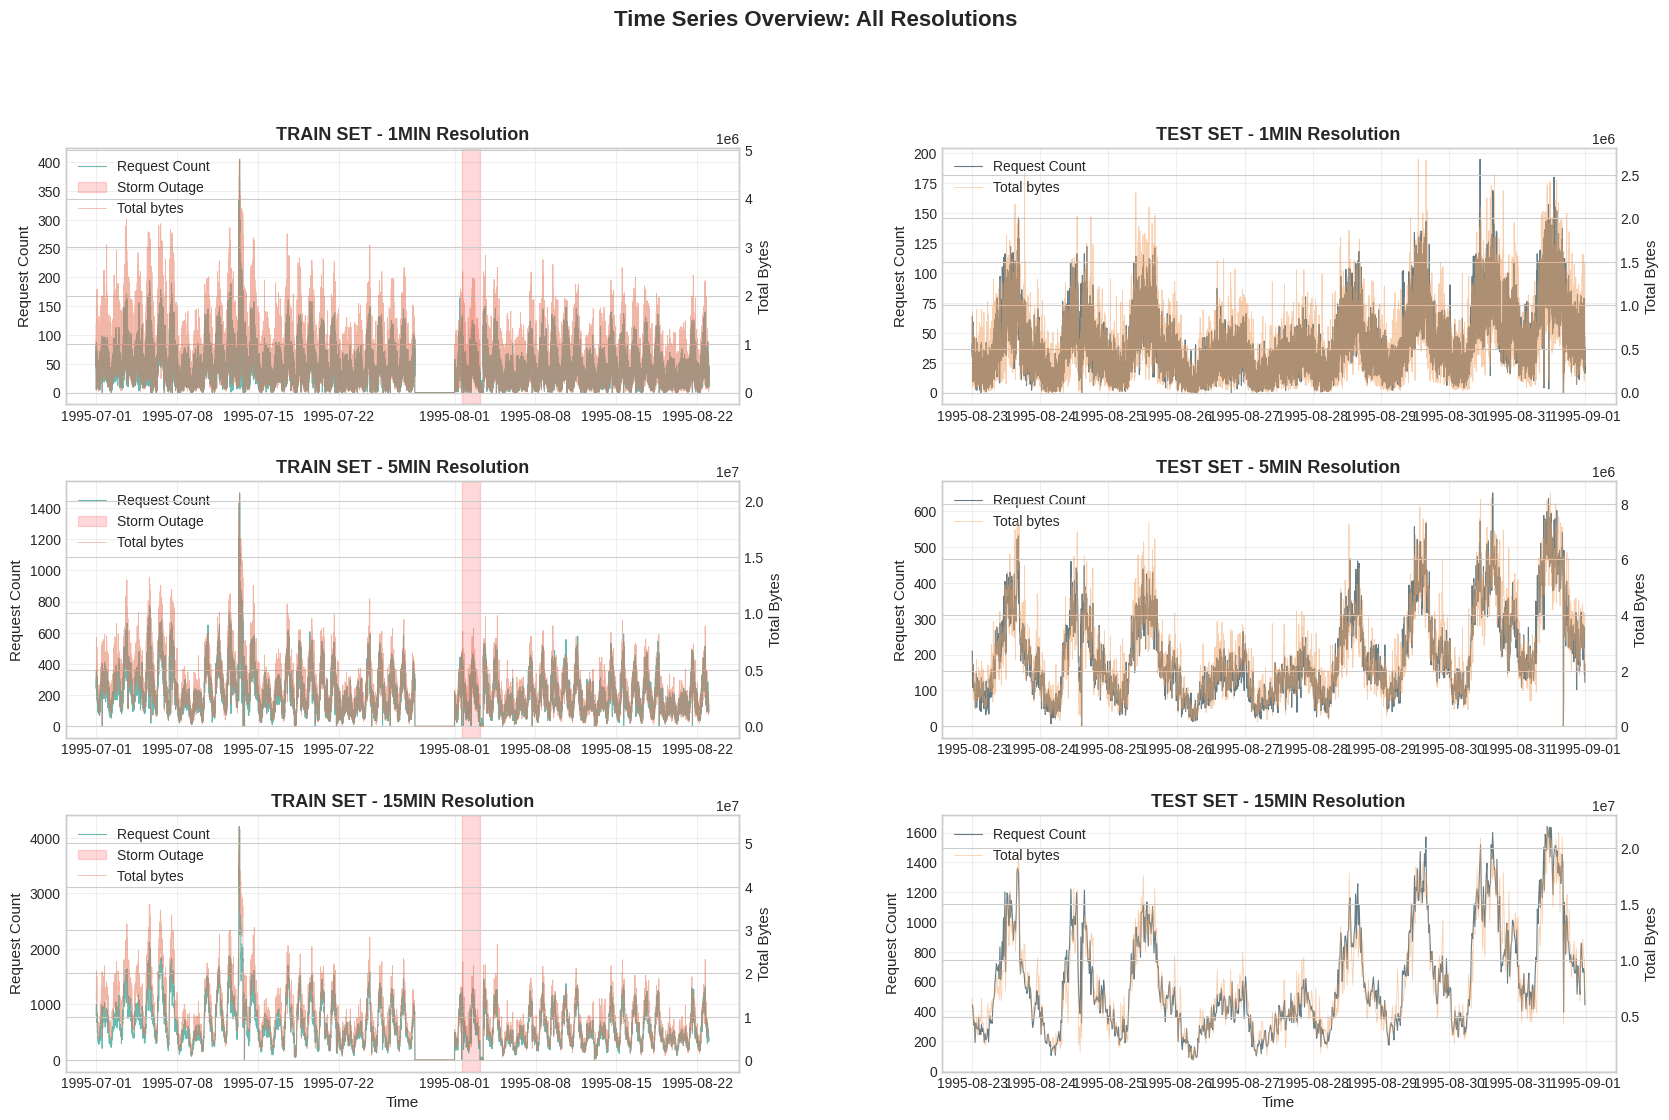


TIME SERIES SUMMARY STATISTICS


1MIN Resolution:
----------------------------------------
Train:
  Periods: 76,320
  Mean RPS: 39.58
  Std RPS: 30.22
  CV: 0.764
  Max RPS: 405
  Outage periods (in Storm): 2,264

Test:
  Periods: 12,960
  Mean RPS: 40.53
  Std RPS: 26.98

5MIN Resolution:
----------------------------------------
Train:
  Periods: 15,264
  Mean RPS: 197.91
  Std RPS: 139.88
  CV: 0.707
  Max RPS: 1,497
  Outage periods (in Storm): 453

Test:
  Periods: 2,592
  Mean RPS: 202.65
  Std RPS: 122.42

15MIN Resolution:
----------------------------------------
Train:
  Periods: 5,088
  Mean RPS: 593.66
  Std RPS: 406.50
  CV: 0.685
  Max RPS: 4,204
  Outage periods (in Storm): 151

Test:
  Periods: 864
  Mean RPS: 607.96
  Std RPS: 355.02

✅ Time series overview complete


In [11]:
# ===========================================================================================
# CELL 5.1: COMPREHENSIVE TIME SERIES VISUALIZATION (FIXED)
# ===========================================================================================
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

def plot_timeseries_overview(train_ts, test_ts, resolutions=['1min', '5min', '15min']):
    """
    Create comprehensive overview of time series data.
    Fixed: Uses hardcoded Storm Timestamps instead of missing 'is_outage' column.
    """

    # Định nghĩa thời gian bão (Theo đề bài)
    STORM_START = pd.Timestamp("1995-08-01 14:52:01")
    STORM_END   = pd.Timestamp("1995-08-03 04:36:13")

    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(len(resolutions), 2, figure=fig, hspace=0.3, wspace=0.3)

    for i, res in enumerate(resolutions):
        # Lấy data (copy để không ảnh hưởng gốc)
        train_data = train_ts[res].copy()
        test_data = test_ts[res].copy()

        # --- PLOT 1: TRAIN SET ---
        ax1 = fig.add_subplot(gs[i, 0])

        # Request count
        ax1.plot(train_data.index, train_data['request_count'],
                 color='#2a9d8f', linewidth=0.8, alpha=0.7, label='Request Count')

        # Weighted load (Total bytes)
        ax1_twin = ax1.twinx()
        if 'total_bytes' in train_data.columns:
            ax1_twin.plot(train_data.index, train_data['total_bytes'],
                          color='#e76f51', linewidth=0.6, alpha=0.5, label='Total bytes')

        # [FIX] Highlight outage period bằng Timestamp thay vì cột 'is_outage'
        # Chỉ vẽ nếu khung thời gian của data có chứa đoạn bão
        if (train_data.index.min() <= STORM_END) and (train_data.index.max() >= STORM_START):
            ax1.axvspan(STORM_START, STORM_END,
                        color='red', alpha=0.15, label='Storm Outage')

        ax1.set_title(f'TRAIN SET - {res.upper()} Resolution', fontweight='bold', fontsize=13)
        ax1.set_ylabel('Request Count', fontsize=11)
        ax1_twin.set_ylabel('Total Bytes', fontsize=11)

        # Gom legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        ax1.grid(True, alpha=0.3)

        # --- PLOT 2: TEST SET ---
        ax2 = fig.add_subplot(gs[i, 1])

        ax2.plot(test_data.index, test_data['request_count'],
                 color='#264653', linewidth=0.8, alpha=0.7, label='Request Count')

        ax2_twin = ax2.twinx()
        if 'total_bytes' in test_data.columns:
            ax2_twin.plot(test_data.index, test_data['total_bytes'],
                          color='#f4a261', linewidth=0.6, alpha=0.5, label='Total bytes')

        ax2.set_title(f'TEST SET - {res.upper()} Resolution', fontweight='bold', fontsize=13)
        ax2.set_ylabel('Request Count', fontsize=11)
        ax2_twin.set_ylabel('Total Bytes', fontsize=11)

        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        ax2.grid(True, alpha=0.3)

        if i == len(resolutions) - 1:
            ax1.set_xlabel('Time', fontsize=11)
            ax2.set_xlabel('Time', fontsize=11)

    plt.suptitle('Time Series Overview: All Resolutions',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.show()

    # --- PRINT SUMMARY STATISTICS ---
    print("\n" + "="*80)
    print("TIME SERIES SUMMARY STATISTICS")
    print("="*80 + "\n")

    for res in resolutions:
        print(f"\n{res.upper()} Resolution:")
        print("-" * 40)

        train_data = train_ts[res]
        test_data = test_ts[res]

        # [FIX] Tính số điểm dữ liệu nằm trong vùng bão dựa trên index
        outage_mask = (train_data.index >= STORM_START) & (train_data.index <= STORM_END)
        outage_count = outage_mask.sum()

        print(f"Train:")
        print(f"  Periods: {len(train_data):,}")
        print(f"  Mean RPS: {train_data['request_count'].mean():.2f}")
        print(f"  Std RPS: {train_data['request_count'].std():.2f}")
        # Thêm check để tránh chia cho 0
        mean_rps = train_data['request_count'].mean()
        cv = train_data['request_count'].std() / mean_rps if mean_rps > 0 else 0
        print(f"  CV: {cv:.3f}")
        print(f"  Max RPS: {train_data['request_count'].max():,}")
        print(f"  Outage periods (in Storm): {outage_count:,}")

        print(f"\nTest:")
        print(f"  Periods: {len(test_data):,}")
        print(f"  Mean RPS: {test_data['request_count'].mean():.2f}")
        print(f"  Std RPS: {test_data['request_count'].std():.2f}")

# Call function
plot_timeseries_overview(train_ts, test_ts)
print("\n✅ Time series overview complete")

BƯỚC 4: KIỂM ĐỊNH TÍNH DỪNG & TỐI ƯU HÓA DỮ LIỆU

>>> ANALYZING RESOLUTION: 1min
  Shape: (76320,)
  Seasonal Period (Daily): 1440 steps

--- [A] RAW DATA TEST ---


/tmp/ipython-input-787410764.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')



[STATIONARITY TESTS - 1min Raw]
  Sample: n=76,320
  Mean: 39.58, Std: 30.22, CV: 0.764

  ADF Test:
    Statistic: -12.1761
    p-value: 0.0000
    Critical value (5%): -2.8616
    Result: ✓ STATIONARY

  KPSS Test:
    Statistic: 0.7915
    p-value: 0.0100
    Critical value (5%): 0.1460
    Result: ✗ NON-STATIONARY

  ⚠️  CONCLUSION: Tests disagree (inconclusive)

--- [B] VARIANCE STABILIZATION (BOX-COX) ---

[BOX-COX TRANSFORMATION]
  Optimal λ: 0.4727
  Interpretation: Power transformation (λ=0.473)

  Before: σ=30.22
  After:  σ=4.48
  Variance reduction: 85.2%

--- [C] REMOVE SEASONALITY & TREND ---
  -> Applying Seasonal Differencing (Lag 1440)...
  -> Applying First-order Differencing (Lag 1)...

[DIFFERENCING]
  Order: 1
  Original length: 74,880
  Differenced length: 74,879
  Lost observations: 1

--- [D] FINAL TRANSFORMED DATA TEST ---


/tmp/ipython-input-787410764.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')



[STATIONARITY TESTS - 1min Transformed]
  Sample: n=74,879
  Mean: 0.00, Std: 3.19, CV: 29979.953

  ADF Test:
    Statistic: -91.5566
    p-value: 0.0000
    Critical value (5%): -2.8616
    Result: ✓ STATIONARY

  KPSS Test:
    Statistic: 0.0110
    p-value: 0.1000
    Critical value (5%): 0.1460
    Result: ✓ STATIONARY

  ✅ CONCLUSION: Series is STATIONARY (both tests agree)


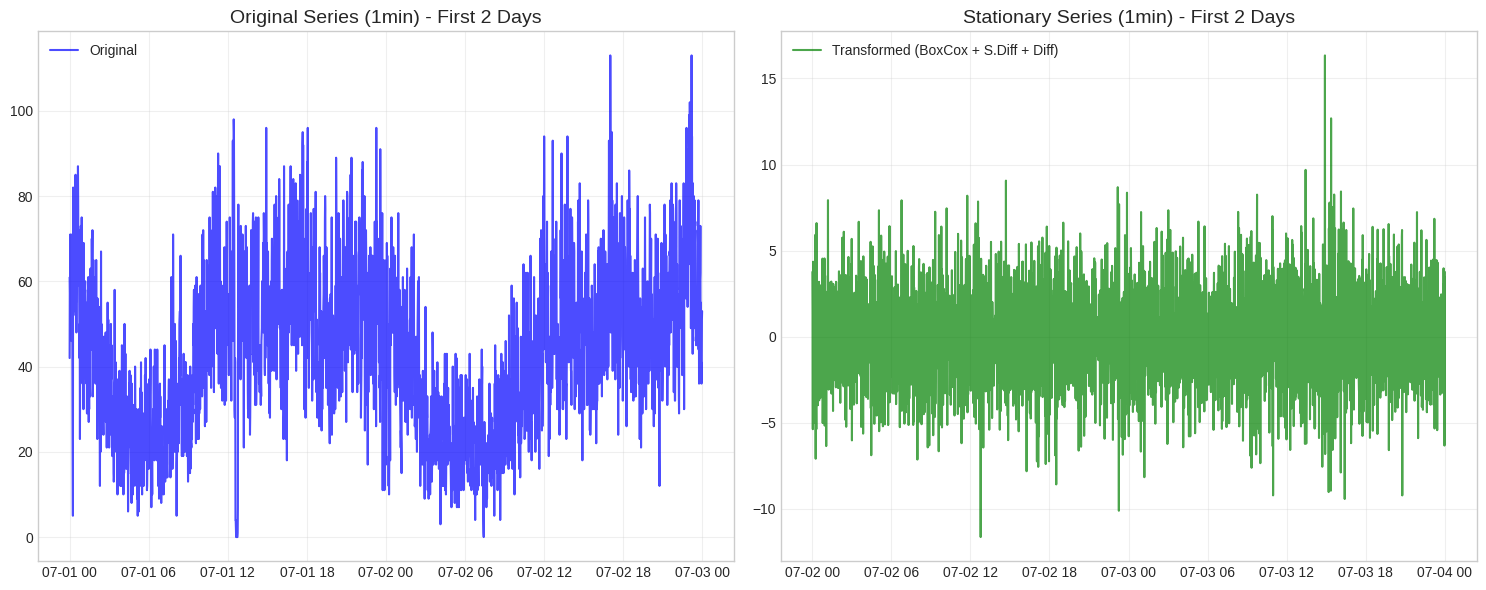


>>> ANALYZING RESOLUTION: 5min
  Shape: (15264,)
  Seasonal Period (Daily): 288 steps

--- [A] RAW DATA TEST ---

[STATIONARITY TESTS - 5min Raw]
  Sample: n=15,264
  Mean: 197.91, Std: 139.88, CV: 0.707

  ADF Test:
    Statistic: -7.9283
    p-value: 0.0000
    Critical value (5%): -2.8617
    Result: ✓ STATIONARY

  KPSS Test:
    Statistic: 0.4057
    p-value: 0.0100
    Critical value (5%): 0.1460
    Result: ✗ NON-STATIONARY

  ⚠️  CONCLUSION: Tests disagree (inconclusive)

--- [B] VARIANCE STABILIZATION (BOX-COX) ---


/tmp/ipython-input-787410764.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')



[BOX-COX TRANSFORMATION]
  Optimal λ: 0.5340
  Interpretation: Power transformation (λ=0.534)

  Before: σ=139.88
  After:  σ=12.56
  Variance reduction: 91.0%

--- [C] REMOVE SEASONALITY & TREND ---
  -> Applying Seasonal Differencing (Lag 288)...
  -> Applying First-order Differencing (Lag 1)...

[DIFFERENCING]
  Order: 1
  Original length: 14,976
  Differenced length: 14,975
  Lost observations: 1

--- [D] FINAL TRANSFORMED DATA TEST ---

[STATIONARITY TESTS - 5min Transformed]
  Sample: n=14,975
  Mean: 0.00, Std: 6.62, CV: 26395.301

  ADF Test:
    Statistic: -37.0560
    p-value: 0.0000
    Critical value (5%): -2.8617
    Result: ✓ STATIONARY

  KPSS Test:
    Statistic: 0.0130
    p-value: 0.1000
    Critical value (5%): 0.1460
    Result: ✓ STATIONARY

  ✅ CONCLUSION: Series is STATIONARY (both tests agree)


/tmp/ipython-input-787410764.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')


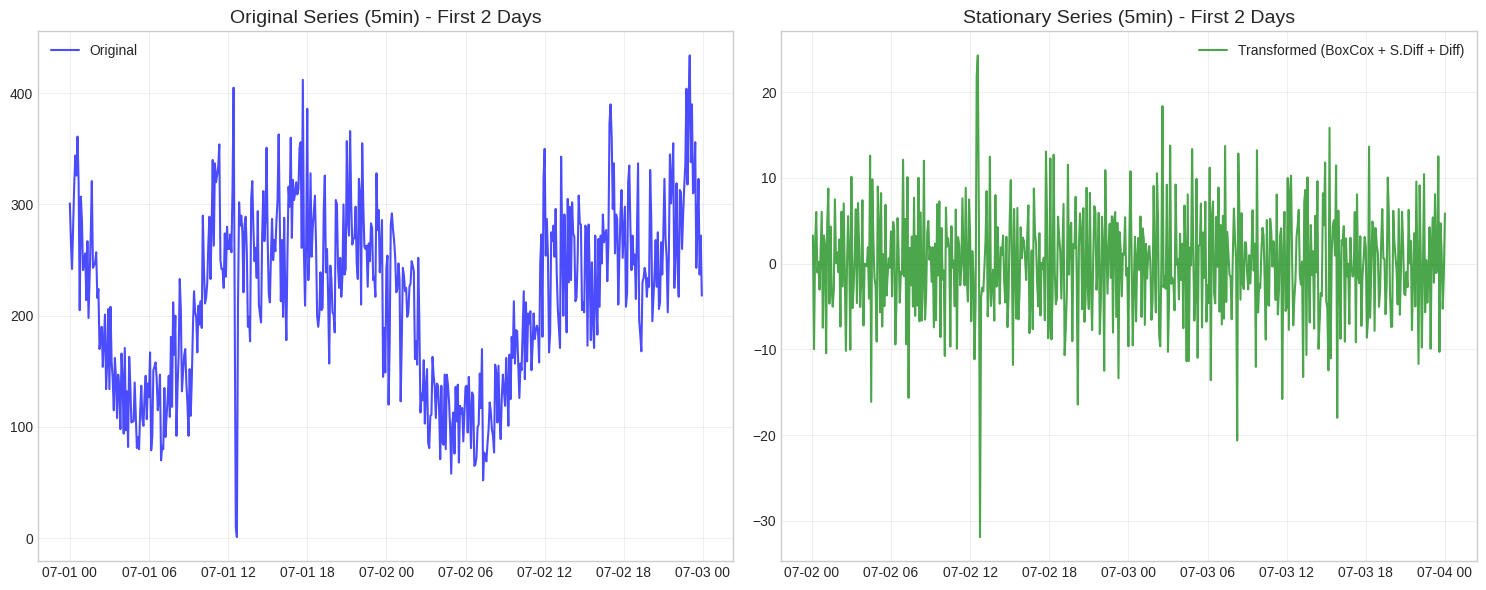


>>> ANALYZING RESOLUTION: 15min
  Shape: (5088,)
  Seasonal Period (Daily): 96 steps

--- [A] RAW DATA TEST ---

[STATIONARITY TESTS - 15min Raw]
  Sample: n=5,088
  Mean: 593.66, Std: 406.50, CV: 0.685

  ADF Test:
    Statistic: -10.1247
    p-value: 0.0000
    Critical value (5%): -2.8621
    Result: ✓ STATIONARY

  KPSS Test:
    Statistic: 0.3035
    p-value: 0.0100
    Critical value (5%): 0.1460
    Result: ✗ NON-STATIONARY

  ⚠️  CONCLUSION: Tests disagree (inconclusive)

--- [B] VARIANCE STABILIZATION (BOX-COX) ---

[BOX-COX TRANSFORMATION]
  Optimal λ: 0.5431
  Interpretation: Power transformation (λ=0.543)

  Before: σ=406.50
  After:  σ=23.43
  Variance reduction: 94.2%

--- [C] REMOVE SEASONALITY & TREND ---
  -> Applying Seasonal Differencing (Lag 96)...
  -> Applying First-order Differencing (Lag 1)...

[DIFFERENCING]
  Order: 1
  Original length: 4,992
  Differenced length: 4,991
  Lost observations: 1

--- [D] FINAL TRANSFORMED DATA TEST ---

[STATIONARITY TESTS - 15m

/tmp/ipython-input-787410764.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/tmp/ipython-input-787410764.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')


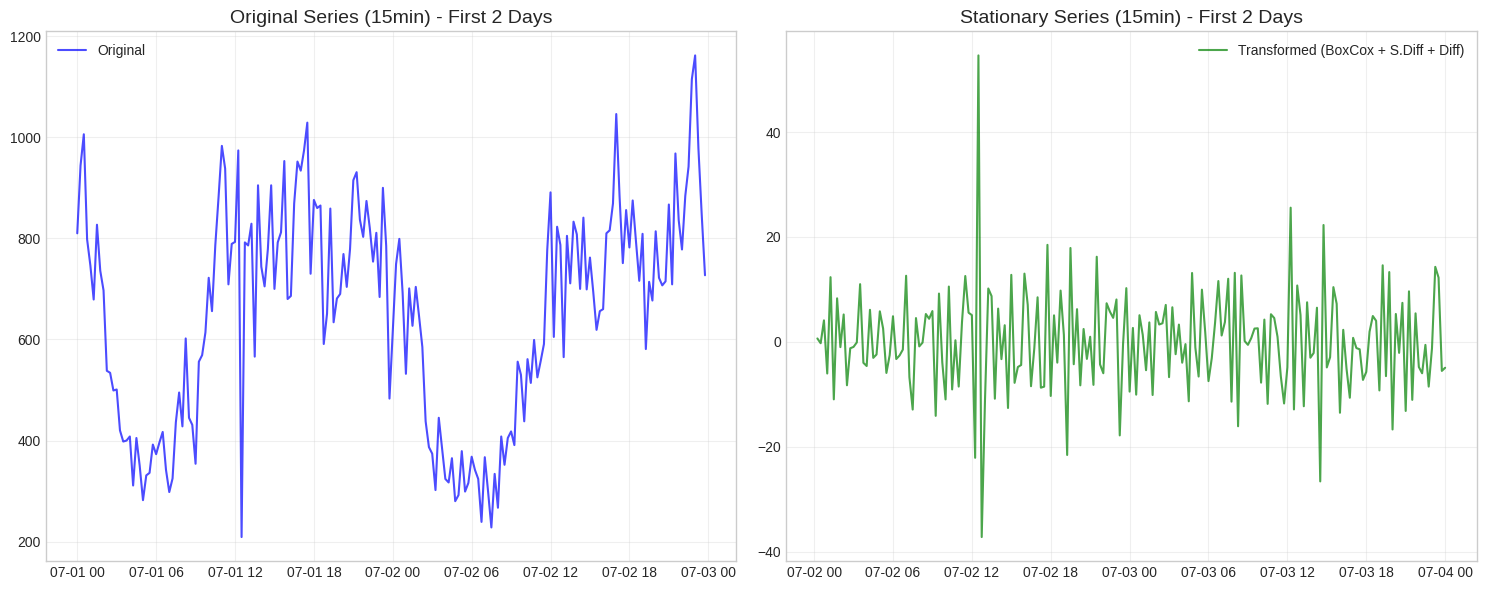


✓ Hoàn tất phân tích tính dừng trên mọi độ phân giải.


In [12]:
# ===========================================================================================
# CELL 5.1: EXECUTE STATIONARITY ANALYSIS (MULTI-RESOLUTION)
# ===========================================================================================
import matplotlib.pyplot as plt

print("="*80)
print("BƯỚC 4: KIỂM ĐỊNH TÍNH DỪNG & TỐI ƯU HÓA DỮ LIỆU")
print("="*80)

# Cấu hình chu kỳ mùa vụ (Seasonality) cho từng độ phân giải
# Web traffic thường có chu kỳ ngày (24h)
seasonal_periods = {
    '1min': 24 * 60,      # 1440 điểm/ngày
    '5min': 24 * 12,      # 288 điểm/ngày
    '15min': 24 * 4       # 96 điểm/ngày
}

analysis_results = {}

for res in ['1min', '5min', '15min']:
    print(f"\n{'='*40}")
    print(f">>> ANALYZING RESOLUTION: {res}")
    print(f"{'='*40}")

    # 1. Lấy dữ liệu
    # Chỉ lấy request_count để phân tích mẫu
    if res not in train_ts:
        print(f"Skipping {res}: Data not found.")
        continue

    series_raw = train_ts[res]['request_count']
    period = seasonal_periods[res]

    print(f"  Shape: {series_raw.shape}")
    print(f"  Seasonal Period (Daily): {period} steps")

    # ---------------------------------------------------------
    # BƯỚC A: KIỂM TRA DỮ LIỆU GỐC (RAW)
    # ---------------------------------------------------------
    print(f"\n--- [A] RAW DATA TEST ---")
    test_stationarity(series_raw, name=f"{res} Raw", verbose=True)

    # ---------------------------------------------------------
    # BƯỚC B: ỔN ĐỊNH PHƯƠNG SAI (BOX-COX)
    # ---------------------------------------------------------
    print(f"\n--- [B] VARIANCE STABILIZATION (BOX-COX) ---")
    series_boxcox, lam = apply_boxcox(series_raw, return_lambda=True, verbose=True)

    # ---------------------------------------------------------
    # BƯỚC C: LOẠI BỎ MÙA VỤ & XU HƯỚNG (DIFFERENCING)
    # ---------------------------------------------------------
    print(f"\n--- [C] REMOVE SEASONALITY & TREND ---")

    # 1. Seasonal Differencing (Trừ đi ngày hôm qua) -> Loại bỏ chu kỳ ngày
    print(f"  -> Applying Seasonal Differencing (Lag {period})...")
    series_seasonal_diff = apply_differencing(series_boxcox, order=0, seasonal_period=period, verbose=False)

    # 2. Regular Differencing (Trừ đi 5 phút trước) -> Loại bỏ Trend còn sót lại
    print(f"  -> Applying First-order Differencing (Lag 1)...")
    series_final = apply_differencing(series_seasonal_diff, order=1, verbose=True)

    # ---------------------------------------------------------
    # BƯỚC D: KIỂM TRA LẠI (FINAL TEST)
    # ---------------------------------------------------------
    print(f"\n--- [D] FINAL TRANSFORMED DATA TEST ---")
    final_stats = test_stationarity(series_final, name=f"{res} Transformed", verbose=True)

    # Lưu kết quả để dùng sau này
    analysis_results[res] = {
        'lambda': lam,
        'final_series': series_final,
        'is_stationary': final_stats.get('adf_stationary', False) and final_stats.get('kpss_stationary', False)
    }

    # ---------------------------------------------------------
    # BƯỚC E: VISUALIZATION (SO SÁNH TRỰC QUAN)
    # ---------------------------------------------------------
    plt.figure(figsize=(15, 6))

    # Vẽ dữ liệu gốc
    plt.subplot(1, 2, 1)
    plt.plot(series_raw.head(period*2), label='Original', color='blue', alpha=0.7)
    plt.title(f'Original Series ({res}) - First 2 Days')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Vẽ dữ liệu đã biến đổi
    plt.subplot(1, 2, 2)
    plt.plot(series_final.head(period*2), label='Transformed (BoxCox + S.Diff + Diff)', color='green', alpha=0.7)
    plt.title(f'Stationary Series ({res}) - First 2 Days')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n✓ Hoàn tất phân tích tính dừng trên mọi độ phân giải.")

In [ ]:
# ===========================
# CELL 16: EXPORT PROCESSED DATA (KAGGLE VERSION)
# ===========================
import os
import pandas as pd
import numpy as np

print("\n" + "="*60)
print("BƯỚC CUỐI: XUẤT DỮ LIỆU ĐÃ XỬ LÝ (EXPORT DATA - KAGGLE)")
print("="*60 + "\n")

# ---------------------------------------------------------
# 1. CẤU HÌNH ĐƯỜNG DẪN 
# ---------------------------------------------------------
# Bạn có thể đổi version folder

BASE_DIR = f'data'

try:
    os.makedirs(BASE_DIR, exist_ok=True)
    print(f"📂 Thư mục lưu trữ: {BASE_DIR}")
except Exception as e:
    print(f"❌ LỖI: Không thể tạo thư mục. ({e})")

# Hàm hỗ trợ in thông tin file
def print_file_info(path):
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"   -> Saved: {os.path.basename(path)} ({size_mb:.2f} MB)")
    else:
        print(f"   -> ⚠️ Không tìm thấy file {os.path.basename(path)}")

# ---------------------------------------------------------
# 2. EXPORT TIME SERIES (TRAIN / TEST)
# ---------------------------------------------------------
if 'train_ts' in globals() and 'test_ts' in globals():
    print(f"\n[1] Exporting Time Series ({len(train_ts)} resolutions)...")

    for res in train_ts.keys():
        # Train
        train_path = f"{BASE_DIR}/train_{res}.csv"
        train_ts[res].to_csv(train_path)
        print_file_info(train_path)

        # Test
        test_path = f"{BASE_DIR}/test_{res}.csv"
        test_ts[res].to_csv(test_path)
        print_file_info(test_path)
else:
    print("\n⚠️ BỎ QUA: Không tìm thấy 'train_ts' hoặc 'test_ts'.")

# ---------------------------------------------------------
# 3. EXPORT SESSION DATA
# ---------------------------------------------------------
if 'all_sessions' in globals():
    print(f"\n[2] Exporting Session Data...")
    session_path = f"{BASE_DIR}/sessions_data.csv"
    all_sessions.to_csv(session_path, index=False)
    print_file_info(session_path)
else:
    print("\nℹ️ INFO: Không tìm thấy 'all_sessions'.")

# ---------------------------------------------------------
# 4. EXPORT STATISTICAL REPORTS
# ---------------------------------------------------------
report_var = None
if 'analysis_results' in globals():
    report_var = analysis_results
elif 'reports' in globals():
    report_var = reports

if report_var:
    print(f"\n[3] Exporting Statistical Reports...")

    for res, data in report_var.items():
        report_path = f"{BASE_DIR}/stats_report_{res}.csv"

        if isinstance(data, dict):
            clean_dict = {
                k: v for k, v in data.items()
                if not isinstance(v, (pd.Series, pd.DataFrame, np.ndarray))
            }
            pd.DataFrame.from_dict(
                clean_dict, orient='index', columns=['Value']
            ).to_csv(report_path)

        elif isinstance(data, pd.DataFrame):
            data.to_csv(report_path)

        print_file_info(report_path)
else:
    print("\nℹ️ INFO: Không tìm thấy báo cáo thống kê.")

print("\n" + "="*60)
print("="*60)



BƯỚC CUỐI: XUẤT DỮ LIỆU ĐÃ XỬ LÝ (EXPORT DATA - KAGGLE)

📂 Thư mục lưu trữ: /content/drive/MyDrive/AUTOSCALING ANALYSIS/PROCESSED_DATAFINAL

[1] Exporting Time Series (3 resolutions)...
   -> Saved: train_1min.csv (4.20 MB)
   -> Saved: test_1min.csv (0.73 MB)
   -> Saved: train_5min.csv (0.91 MB)
   -> Saved: test_5min.csv (0.16 MB)
   -> Saved: train_15min.csv (0.31 MB)
   -> Saved: test_15min.csv (0.05 MB)

ℹ️ INFO: Không tìm thấy 'all_sessions'.

[3] Exporting Statistical Reports...
   -> Saved: stats_report_1min.csv (0.00 MB)
   -> Saved: stats_report_5min.csv (0.00 MB)
   -> Saved: stats_report_15min.csv (0.00 MB)

